<a href="https://colab.research.google.com/github/raulbenitez/ZUMAIN_course/blob/main/MNIST_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST data exploration

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Visualize image dataset 

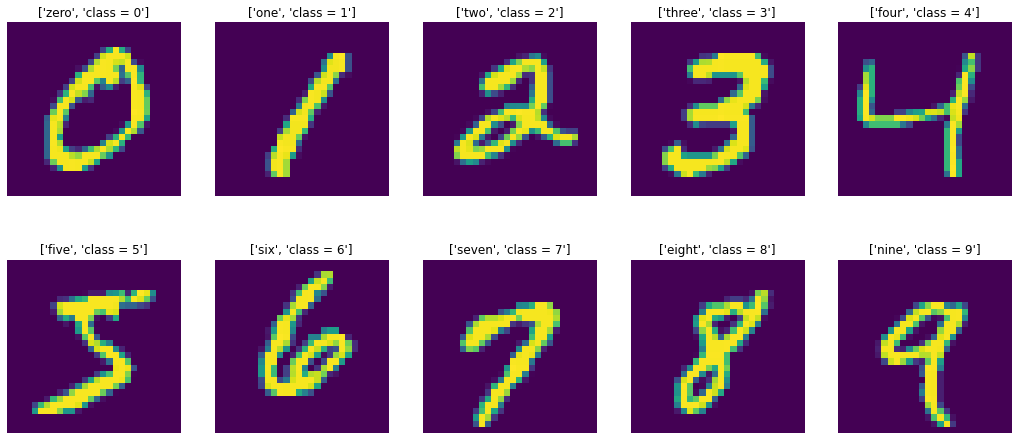

In [ ]:
import skimage as sk # load skimage libraries
from skimage import io
import matplotlib.pylab as plt

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

fig = plt.figure(figsize=(18, 8))

for kclass in range(0,10):
    ind = np.argwhere(y_train==kclass)
    ax = fig.add_subplot(2, 5, kclass+1)
    ax.imshow(x_train[ind[0][0]].squeeze())
    ax.set_title([label_names[kclass], 'class = {}'.format(kclass)])
    ax.axis('off')

# Low-dimension projections of the MNIST test data subset

## PCA projection

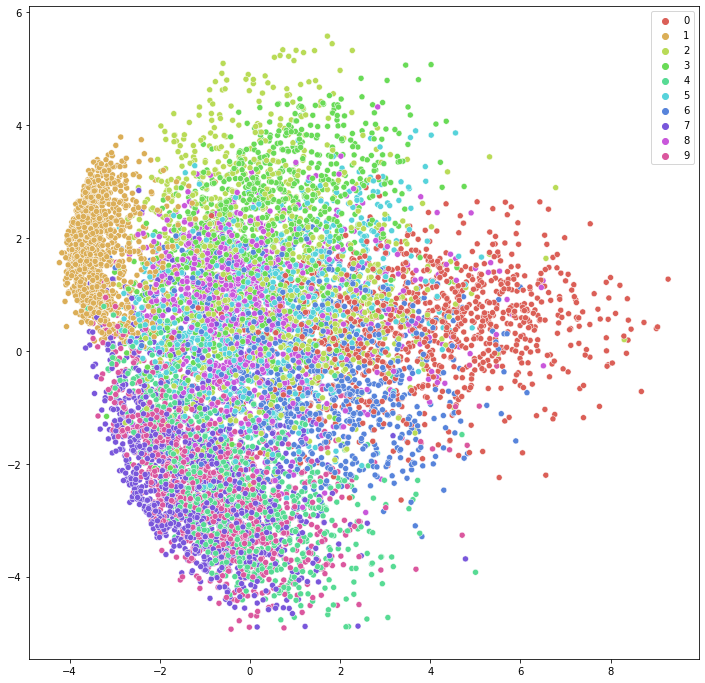

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Reshape as NOBSERVATIONS x NPIXELS:
train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])


# Scale (Standardization)
train = StandardScaler().fit_transform(test)

# PROJECT TO A 2D PCA SPACE:
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(test)

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = pca_proj[:,0], y = pca_proj[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full')

No surprise that all classes are entangled in the 2d PCA projection since the variance explained by a 2D PCA projection is only a fraction of the total variability:

In [ ]:
pca.explained_variance_ratio_.cumsum()

array([0.10047698, 0.1759221 ], dtype=float32)

## T-SNE projection

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf



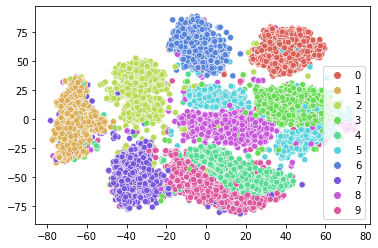

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(test)

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');


# PCA + t-SNE

Let's first project into a PCA space explaining 95% of the variability and then visualize the PCA projection using a 2D t-SNE manifold

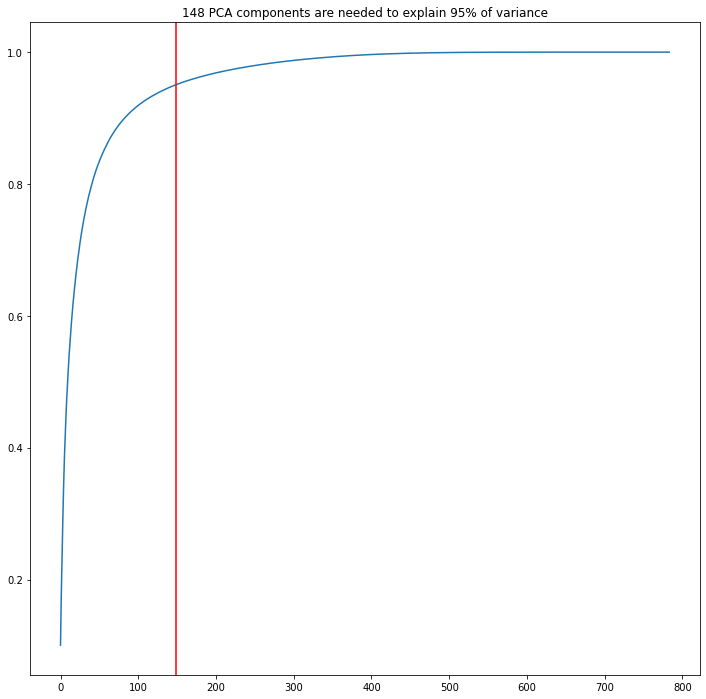

In [ ]:
pca_full = PCA(n_components=test.shape[1])
pca_full.fit(test)

cummulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Find number of components needed to explain 95% of variance:
ind= np.argwhere(cummulative_variance>0.95)
Ncomponents_95 = ind[0].item()

fig = plt.figure(figsize=(7,7))
plt.plot(cummulative_variance)
plt.axvline(Ncomponents_95,c='r')
plt.title('{} PCA components are needed to explain 95% of variance'.format(Ncomponents_95))
plt.show()

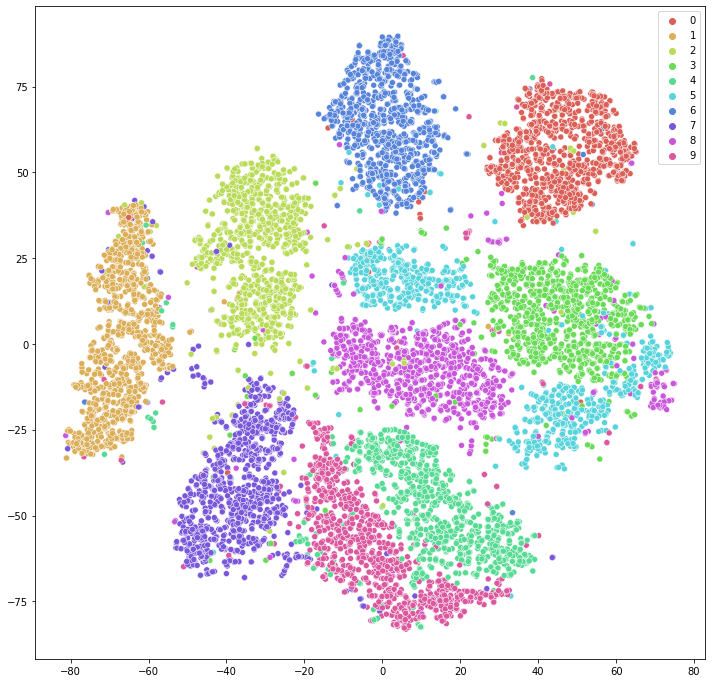

In [ ]:
pca95 = PCA(n_components=Ncomponents_95)
pca95_proj = pca95.fit_transform(test)

tsne = TSNE(n_components = 2, random_state=0)
tsne_pca = tsne.fit_transform(pca95_proj)

fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = tsne_pca[:,0], y = tsne_pca[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

PCA as feature extraction works pretty well (eigenfaces)

## UMAP Projection

https://arxiv.org/abs/1802.03426

https://umap-learn.readthedocs.io/en/latest/

First, install UMAP library in google colab platform

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 1.2MB 8.3MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=0d2c5b1a7b53606ebb5026da81d7568cd4d84e96e4f8065c1970d8ba7eac96ca
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51362 sha256=d4e63d85a1ac4905d0e37676019bc17be4730061cf309ed9a2e9ea224d3bc649
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
import umap
embedding = umap.UMAP(n_neighbors=5).fit_transform(test)

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.3, c=y_train, cmap='Spectral', alpha=1.0)
plt.title('MNIST Embedded via UMAP');